## Librairies

In [17]:
import landaupy
from landaupy import landau
import matplotlib.pyplot as plt
import numpy as np
from random import gauss

## Parameters

We will begin by defining the particles and their masses (in GeV/c²)

In [18]:
#Electron:
m_e=5.11*10**-4

#s-quark:
m_s=93*10**-3

#B⁺-meson:
m_B=5279.34*10**-3

#Proton:
m_p=938.27*10**-3

In the following, we work in a $(z,y)$ axis system, as in figure 5.1.

In [19]:
#Constants:

c=3*10**8 #Speed of light in m.s^{-1}

#Parameters:

q=0.3 #for a particle with a charge 1.6*10**-19 C
e=1.6*10**-19 #Elementary charge
B=1 #Magnetic field in T
L=0.01 #length of the magnetic zone, in m
d=0.005 #length of the dectectors


d1=0.0125 #distance between the particle gun and the first sensor
d2=0.0075 #distance bewteen the second sensor and the magnetic zone
d3=0.0075 #distance between the magnetic zone and the third sensor

Let's define the system such that the particle come from the right to left, as in the figure.

In [39]:
#Initial position:

z0=0.05
y0=0.005

#Arbitrary initial momentum in GeV/c:

p_z0=-6
p_y0=0

#Standard deviation:
sigma=0.000001

For the Pixel Firing Threshold and the Multiple scattering, we need to introduce other constants:

In [21]:
j=0.200 #density effect correctged on disk since the last time we opened or saved it. Do you want ion
ze=14 #Number of electrons of the detector's atom
th=14*10**-6 #detector thickness (in m)
rho=2.2 #density of detector (in g/cm3)
x=rho*th #ged on disk since the last time we opened or saved it. Do you want detector thickness (in g/cm2)
threshold=100 #roughly 100e-
ratio_ZA=0.49930
Wi=3.6 #minimum energy required to create an electron-hole pair for Si (in eV)

Now we implement the Landau distribution:

In [22]:
def most_probable_value(Z,m):
    #Needed parameters:
    v0=np.sqrt((p_z0/m)**2+(p_y0/m)**2)
    beta=v0/c
    g=np.sqrt(1-beta**2) #inverse Lorentz coefficient
    
    #Parameters related to the Landau distribution:
    ksi=(0.1535*ze**2*rho)*ratio_ZA*(x/(beta**2)) #Parameter of the Landau distribution
    w=4.018*ksi #width of Landau distribution
    
    #Computation of the 'I' parameter:
    if Z<13:
        I=12+7/Z #average excitation energy
    else:
        I=9.76+58.8*(Z**(-1.19))
        
    #Most Probable Value formula:
    delta_p=ksi*(np.log((2*m_e*10**9*((beta)/g)**2)/I)+np.log(ksi/I)+j-beta**2) #most probable value
    
    return(delta_p)

In [23]:
Z=14 #In our case, the detector is composed of Silicon only

We have to troncate the values obtain from the Landau distribution

In [24]:
def energy_deposit(m):
    a=landau.sample(x_mpv=most_probable_value(Z,m), xi=w, n_samples=1)#We generate a value for the energy deposited
    #x_mpv is the most probable energy of Landau distribution
    #xi is the width
    
    if a<0 or a*10**-9>np.sqrt(p_y0**2+p_z0**2):
        return energy_deposit(m)
    
    else:
        return a

## Kinematics

Now we need to introduce the kinematics of the particle in each of the three zone: before B-field (first zone), inside B-field, after B-field.

In [25]:
def Kinematic_First_Zone(z,y,pz,py,m):
    "Arguments: (z,y), the position at the entrance of the first zone (position of the particle gun); "
    "(pz,py) the momenta at the entrance of the first zone; m, the mass of the particle."
    "Return: lists of the positions and the velocities of the particle at each instant; 'i' the last used index."
    
    dt=0.0000001 #Time step
    
    Z,Y,Vz,Vy=[],[],[],[] #Lists of positions and velocities
    
    #Initial velocities
    vz=pz/m
    vy=py/m
    
    #Implementation of the initial conditions:
    Z.append(z)
    Y.append(y)
    Vz.append(vz)
    Vy.append(vy)
    
    i=0
    e_dep=0 #energy deposited
    
    while Z[i]>Z[0]-(d1+d+d2):
        if Z[i]==d1 or Z[i]==d1+d:
            e_dep = energy_deposit()
            
        
        #Computation of the coordinates of the velocity
        Vz.append(Vz[i])
        Vy.append(Vy[i])
        
        #Computation of the coordinates of the positions
        Z.append(Z[i]+Vz[i]*dt)
        Y.append(Y[i]+Vy[i]*dt)
        
        i=i+1
        
    return (Z,Y,Vz,Vy,i)

In [26]:
def Kinematic_B_Field(z,y,pz,py,m):
    "Arguments: (z,y), the position at the entrance of the magnetic zone;" 
    "(pz,py), the momenta at the entrance of the magnetic zone; m, the mass of the particle."
    "Return: lists of the positions and the velocities of the particle at each instant; 'i' the last used index"
    
    dt=0.00001 #Time step
    
    Z,Y,Vz,Vy=[],[],[],[] #Lists of positions and velocities
    
    v=0 #Velocity
    g=0 #Inverse Lorentz coefficient
    
    #Initial velocities
    vz=pz/m
    vy=py/m
    
    #Implementation of the initial conditions:
    Z.append(z)
    Y.append(y)
    Vz.append(vz)
    Vy.append(vy)
    
    i=0 #Index
    
    v0=np.sqrt((Vz[0]**2+Vy[0]**2))
    
    while Z[i]>Z[0]-L: #While the particle is inside the magnetic zone
        #Computation of v and g
        v=np.sqrt((Vz[i]**2+Vy[i]**2))
        g=np.sqrt(1-(v/c)**2)
        
        #Computation of the velocities
        Vz.append(-v*np.cos(q*B*g*i*dt/m))
        Vy.append(-v*np.sin(q*B*g*i*dt/m))
        
        #Computation of the positions
        Z.append(-v*m/(g*q*B)*np.sin(q*B*g*i*dt/m)+Z[0])
        Y.append(-v*m/(g*q*B)*(1-np.cos(q*B*g*i*dt/m))+Y[0])
        
        i=i+1
        
    return (Z,Y,Vz,Vy,i)

In [27]:
def plot_Kinematic_B_Field(z,y,vz,vy,m):
    Z,Y,Vz,Vy=[],[],[],[]
    j=0
    
    Z,Y,Vz,Vy,j=Kinematic_B_Field(z,y,vz,vy,m)
    plt.plot(Z,Y)
    plt.show

In [28]:
def Kinematic_Third_Zone(z,y,pz,py,m):
    "Arguments: (z,y), the position at the entrance of the third zone (position after the B-field); "
    "(pz,py) the momenta at the entrance of the third zone; m, the mass of the particle."
    "Return: lists of the positions and the velocities of the particle at each instant; 'i' the last used index; 'k' the index for which the particle is at the third sensor."
    
    dt=0.00001 #Time step
    
    Z,Y,Vz,Vy=[],[],[],[] #Lists of positions and velocities
    
    v=0 #Velocity
    g=0 #Inverse Lorentz coefficient
    
    #Initial velocities
    vz=pz/m
    vy=py/m
    
    #Implementation of the initial conditions:
    Z.append(z)
    Y.append(y)
    Vz.append(vz)
    Vy.append(vy)
    
    k=0 #We will save the index at the corresponding to the third sensor
    i=0
    eps=0.001
    
    while Z[i]>0:
        #Computation of the coordinates of the velocity
        Vz.append(Vz[0])
        Vy.append(Vy[0])
        
        #Computation of the coordinates of the position
        Z.append(Z[i]+Vz[i]*dt)
        Y.append(Y[i]+Vy[i]*dt)
        
        if Z[i]==d3:
            k=i
        
        i=i+1
        
    return (Z,Y,Vz,Vy,i,k)

## Tracker

Now we can define the tracker for one particle, even plot the device and the trajectories:

In [29]:
def Tracker(m):
    "Arguments:"
    "Return: Lists of positions, velocities during the whole experiment;"
    "the index at which the particle reach the 3rd sensor and the last index (4th sensor)"
    
    dt=0.000001 #Time step
    
    Z,Y,Vz,Vy=[],[],[],[] #Lists of positions and velocities
    
    Z1,Y1,Vz1,Vy1=[],[],[],[] #Lists of positions and velocities in the first zone
    
    ZB,YB,VzB,VyB=[],[],[],[] #Lists of positions and velocities in the magnetic field
    
    Z3,Y3,Vz3,Vy3=[],[],[],[] #Lists of positions and velocities in the third zone
    
    #Initial velocities
    v_z0=p_z0/m
    v_y0=p_y0/m
    
    #Implementation of the initial conditions:
    Z1.append(z0)
    Y1.append(y0)
    Vz1.append(v_z0)
    Vy1.append(v_y0)
    
    i=0 #Index
    
    #First zone(particle gun --> beginning magnetic zone):
    Z1,Y1,Vz1,Vy1,i=Kinematic_First_Zone(Z1[0],Y1[0],m*Vz1[0],m*Vy1[0],m)
        
    #Second zone(magnetic zone):
    j=0 #Last index used in the Kinematic_B_Field function
    ZB,YB,VzB,VyB,j=Kinematic_B_Field(Z1[i],Y1[i],m*Vz1[i],m*Vy1[i],m)
    
    #Third Zone(magnetic zone --> end, when y=0)
    k=0
    l=0
    Z3,Y3,Vz3,Vy3,l,k=Kinematic_Third_Zone(ZB[j],YB[j],m*VzB[j],m*VyB[j],m)
    
    #Concatenation:
    Z=Z1+ZB+Z3
    Y=Y1+YB+Y3
    Vz=Vz1+VzB+Vz3
    Vy=Vy1+VyB+Vy3
    
    k=k+j+i
    i=i+j+l #The last used index
    
    return (Z,Y,Vz,Vy,k,i)

In [30]:
def plot_Kinematic(m):
    Z,Y,Vz,Vy=[],[],[],[]
    k,j=0,0
    
    Z,Y,Vz,Vy,k,j=Tracker(m)
    plt.plot(Z,Y)
    plt.xlabel('z in m')
    plt.ylabel('y in m')
    plt.title('Trajectory of the particle in the system')
    plt.show

## Momentum Spectra and mass observation

We will now construct the actual simulation, consisting of a particle launch at a range of momenta, with each of them following a Gaussian distribution.

In [43]:
def Multiple_Reconstruction(m,N):
    "Arguments:"
    "Return: Lists of momenta and reconstructed momenta"
    
    dt=0.000001 #Time step
    
    n=0 #Power of ten
    
    if m//1!=0:
        n=0
    else:
        n=1
        while m//10**-n==0:
            n=n+1
        
    P=[] #List of the momenta
    Pr=[] #List of the reconstructed momenta
    
    for i in range(1,N):
        Z,Y,Vz,Vy=[],[],[],[] #Lists of positions and velocities
    
        Z1,Y1,Vz1,Vy1=[],[],[],[] #Lists of positions and velocities in the first zone

        ZB,YB,VzB,VyB=[],[],[],[] #Lists of positions and velocities in the magnetic field

        Z3,Y3,Vz3,Vy3=[],[],[],[] #Lists of positions and velocities in the third zone
    
        P.append(-10/N*i*10**-n)
        p_zg=gauss(P[i-1],sigma)
    
        #Initial velocities
        v_z0=p_zg/m
        v_y0=p_y0/m

        #Implementation of the initial conditions:
        Z1.append(z0)
        Y1.append(y0)
        Vz1.append(v_z0)
        Vy1.append(v_y0)

        i=0 #Index

        #First zone(particle gun --> beginning magnetic zone):
        Z1,Y1,Vz1,Vy1,i=Kinematic_First_Zone(Z1[0],Y1[0],m*Vz1[0],m*Vy1[0],m)

        #Second zone(magnetic zone):
        j=0 #Last index used in the Kinematic_B_Field function
        ZB,YB,VzB,VyB,j=Kinematic_B_Field(Z1[i],Y1[i],m*Vz1[i],m*Vy1[i],m)

        #Third Zone(magnetic zone --> end, when y=0)
        k=0
        l=0
        Z3,Y3,Vz3,Vy3,l,k=Kinematic_Third_Zone(ZB[j],YB[j],m*VzB[j],m*VyB[j],m)

        #Concatenation:
        Z=Z1+ZB+Z3
        Y=Y1+YB+Y3
        Vz=Vz1+VzB+Vz3
        Vy=Vy1+VyB+Vy3

        k=k+j+i
        i=i+j+l #The last used index
        
        #Reconstruction:
        alpha=0
        pr=0

        #Computation
        alpha=np.arctan((Y[len(Y)-1]-Y[k])/(Z[len(Z)-1]-Z[k]))
        pr=q*np.abs(B)*L/np.sin(alpha)
        
        Pr.append(pr)
    
    return (P,Pr,n)

There we will compute the errors and plot them to analyze if we are able to read the mass from the tracker:

In [44]:
def Multiple_verification(m,N):
    "Arguments:m, the mass of the particle; pt, the initial momentum"
    "Return: the error on the reconstruction"
    
    P,Pr=[],[]
    Eps=[] #List of errors
    n=0
    
    P,Pr,n=Multiple_Reconstruction(m,N)
    
    for i in range(0,len(P)):
        Eps.append((np.abs(np.abs(P[i])-Pr[i])/np.abs(P[i])*100))
    
    return(P,Eps,n)

In [45]:
def plot_error(m,N):
    P,Eps=[],[]
    P_a,Eps_i=[],[]
    n=0
    
    P,Eps,n=Multiple_verification(m,N)
    
    for i in range(0,len(P)):
        P_a.append(np.abs(P[i])*10**-n)
        Eps_i.append(1/Eps[i])
    
    plt.scatter(P_a,Eps_i)
    plt.xlabel('Initial Momenta in GeV/c')
    plt.ylabel('Inverse of the Error after reconstruction')
    plt.show

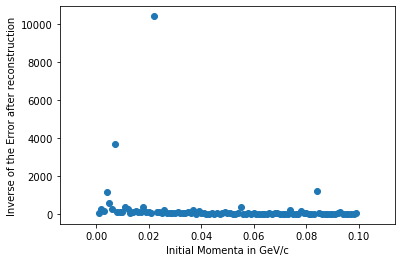

In [46]:
plot_error(m_p,100)